In [22]:
# IMDB 데이터셋 로드

from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000) # train_data에서 자주 나타나는 단어 1만개만 사용

In [23]:
# integer sequence를 binary matrix로 encoding
# one-hot-encoding, list를 tensor로 변환
# data 변환

import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    
    return results

vector_train_data = vectorize_sequences(train_data) # train data 25,000개
vector_test_data = vectorize_sequences(test_data) # test data 25,000개

In [24]:
# label 변환

vector_train_labels = np.asarray(train_labels).astype('float32') # train labels 25,000개
vector_test_labels = np.asarray(test_labels).astype('float32') # test labels 25,000개

In [25]:
# train data 25,000개 >>> partial train data 15,000개 + partial test data 10,000개

# data
partial_train_data = vector_train_data[:15000] # 15,000개
partial_test_data = vector_train_data[15000:] # 10,000개

# labels
partial_train_labels = vector_train_labels[:15000] # 15,000개
partial_test_labels = vector_train_labels[15000:] # 10,000개

In [26]:
# 신경망 모델 만들기

from keras import models
from keras import layers

def build_model():
    model = models.Sequential()

    model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    
    return model

## 3-fold cross validation

> partial_train_data 15,000개로 3-fold cross validation (training + validation)<br/>
> partial_test_data 10,000개로 evaluate 후 hyperparameters tuning해서 overfitting minimizing (강의 내용 범주 안 구현)<br/>
> test_data 25,000개로 최종 evaluate, predict (test)

### 1. 15,000개의 partial train data를 사용하여 3-fold cross validation 결과를 보이시오.

In [27]:
# 3-fold cross validation

k = 3
n_val_samples = len(partial_train_data) // k

n_epochs = 20

loss_scores = []
acc_scores = []

for i in range(k): # i == 0, 1, 2
    print('processing fold #', i)
    
    # 폴드 검증 데이터
    fold_val_data = partial_train_data[i * n_val_samples:(i+1) * n_val_samples]
    fold_val_labels = partial_train_labels[i * n_val_samples:(i+1) * n_val_samples]
    
    # 폴드 훈련 데이터
    fold_train_data = np.concatenate([partial_train_data[:i * n_val_samples], partial_train_data[(i+1) * n_val_samples:]], axis=0)
    fold_train_labels = np.concatenate([partial_train_labels[:i * n_val_samples], partial_train_labels[(i+1) * n_val_samples:]], axis=0)
    
    model = build_model() # 모델 정의
    
    history = model.fit(fold_train_data, # 모델 폴드 훈련
                        fold_train_labels,
                        epochs=n_epochs,
                        batch_size=512,
                        validation_data=(fold_val_data, fold_val_labels),
                        verbose=0)
    
    fold_val_loss, fold_val_acc = model.evaluate(fold_val_data, fold_val_labels, verbose=0)
    
    loss_scores.append(fold_val_loss)
    acc_scores.append(fold_val_acc)

processing fold # 0
processing fold # 1
processing fold # 2


In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [29]:
loss_scores

[0.6391262830257416, 0.6429926848888398, 0.6591549632817507]

In [30]:
acc_scores

[0.8600000143051147, 0.8632000088691711, 0.8636000156402588]

In [31]:
np.mean(loss_scores) # 최종 validation loss

0.6470913103987774

In [32]:
np.mean(acc_scores) # 최종 validation accuracy

0.8622666796048483

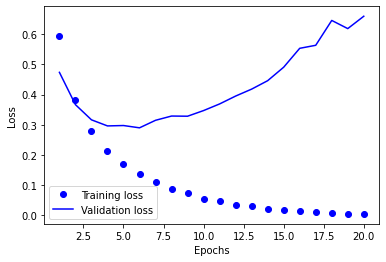

In [33]:
# graph visualization (loss)

import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss'])+1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

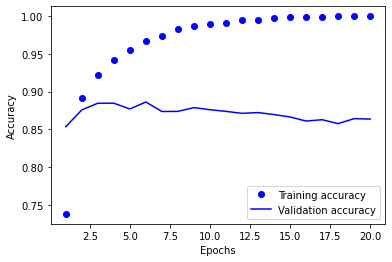

In [34]:
# graph visualization (accuracy)

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(history_dict['acc'])+1)

plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 2. 15,000개의 partial train data와 10,000개의 partial test data를 사용하여 overfitting을 최소로 하는 신경망 모델을 (1) 케라스로 프로그램하고 (2) 그래프 등을 사용하여 결과를 보여주고 (3) 그에 대해 분석 설명하시오.(강의 내용 범주 안에서 구현하시오).
### 여기서 사용되는 test dataset은 원본 25,000 test dataset으로 test 하시오.

> 2-1. 네트워크 크기 축소<br/>
> 2-2. 가중치 규제 추가<br/>
> 2-3. 드롭아웃 추가

## 네트워크 크기 축소

In [89]:
# 네트워크 크기 축소

# 신경망 모델 만들기
def small_size_model():
    model = models.Sequential()
    
    model.add(layers.Dense(6, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(6, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [90]:
small_size_model = small_size_model() # 모델 정의

history = small_size_model.fit(partial_train_data, # 모델 훈련
                               partial_train_labels,
                               epochs=20,
                               batch_size=512,
                               validation_data=(partial_test_data, partial_test_labels), # 모델 검증
                               verbose=0)

In [91]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

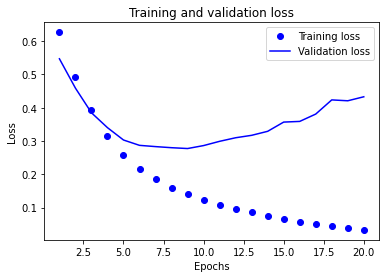

In [92]:
# graph visualization (loss)

import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss'])+1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

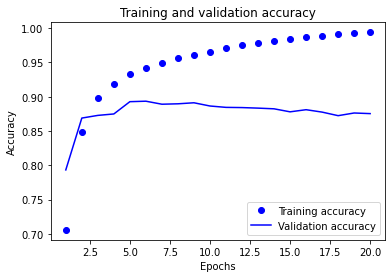

In [93]:
# graph visualization (accuracy)

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(history_dict['acc'])+1)

plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [94]:
small_size_result = small_size_model.evaluate(vector_test_data, vector_test_labels) # 모델 테스트
small_size_result

25000/25000 [==============================] - 3s 128us/step


[0.4775712836718559, 0.8592000007629395]

## 가중치 규제 추가 (L2 규제)

In [95]:
# 가중치 규제 추가 (L2 규제)

# 신경망 모델 만들기
def l2_regularization_model():
    model = models.Sequential()
    
    model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [96]:
from keras import regularizers

l2_regularization_model = l2_regularization_model() # 모델 정의

history = l2_regularization_model.fit(partial_train_data, # 모델 훈련
                                      partial_train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(partial_test_data, partial_test_labels), # 모델 검증
                                      verbose=0)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [ ]:
history_dict = history.history
history_dict.keys()

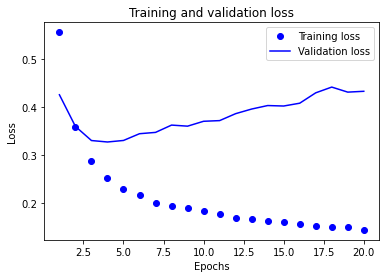

In [97]:
# graph visualization (loss)

import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss'])+1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

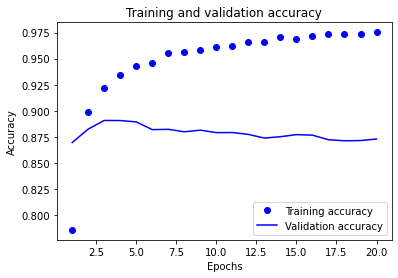

In [98]:
# graph visualization (accuracy)

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(history_dict['acc'])+1)

plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [99]:
l2_regularization_result = l2_regularization_model.evaluate(vector_test_data, vector_test_labels) # 모델 테스트
l2_regularization_result

25000/25000 [==============================] - 3s 131us/step


[0.4584274447917938, 0.8646799921989441]

## 드롭아웃 추가

In [100]:
# 드롭아웃 추가

# 신경망 모델 만들기
def dropout_model():
    model = models.Sequential()
    
    model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [101]:
dropout_model = dropout_model() # 모델 정의

history = dropout_model.fit(partial_train_data, # 모델 훈련
                            partial_train_labels,
                            epochs=20,
                            batch_size=512,
                            validation_data=(partial_test_data, partial_test_labels), # 모델 검증
                            verbose=0)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [ ]:
history_dict = history.history
history_dict.keys()

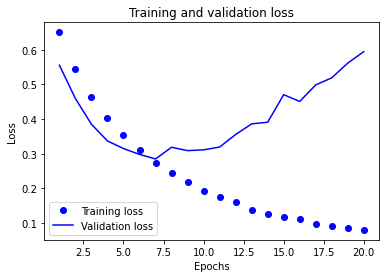

In [102]:
# graph visualization (loss)

import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss'])+1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

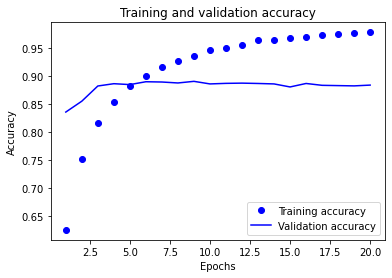

In [103]:
# graph visualization (accuracy)

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(history_dict['acc'])+1)

plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [104]:
dropout_result = dropout_model.evaluate(vector_test_data, vector_test_labels) # 모델 테스트
dropout_result

25000/25000 [==============================] - 3s 137us/step


[0.6058519396340847, 0.8723999857902527]

<hr>
<hr>

In [85]:
# 모델 훈련

build_model = build_model()

history = build_model.fit(partial_train_data,
                          partial_train_labels,
                          epochs=20,
                          batch_size=512,
                          validation_data=(partial_test_data, partial_test_labels),
                          verbose=0)

history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

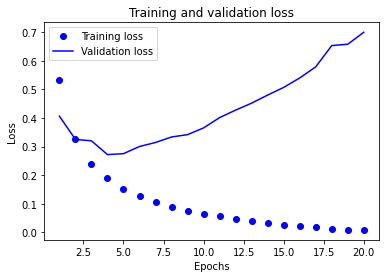

In [86]:
# training, validation loss 그리기

import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

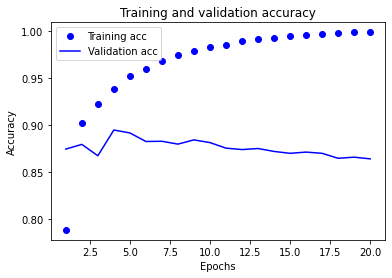

In [87]:
# training, validation accuracy 그리기

plt.clf() # 그래프 초기화

acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [88]:
# 최종 결과 확인

results = build_model.evaluate(vector_test_data, vector_test_labels)
results

25000/25000 [==============================] - 3s 127us/step


[0.7740436159527302, 0.8474000096321106]

<hr>
<hr>

In [16]:
# 모델 재훈련

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)

results = model.evaluate(vector_test_data, vector_test_labels) # test data로 평가

Epoch 1/4
25000/25000 [==============================] - 3s 111us/step - loss: 0.4602 - accuracy: 0.8251
Epoch 2/4
25000/25000 [==============================] - 3s 111us/step - loss: 0.2676 - accuracy: 0.9096
Epoch 3/4
25000/25000 [==============================] - 3s 109us/step - loss: 0.2043 - accuracy: 0.9289
Epoch 4/4
25000/25000 [==============================] - 4s 146us/step


In [18]:
# 새로운 데이터 예측

model.predict(vector_test_data)

array([[0.16196543],
       [0.9999101 ],
       [0.805817  ],
       ...,
       [0.09962112],
       [0.05827034],
       [0.5565213 ]], dtype=float32)